In [ ]:
# INSTALACIÓN DE LIBRERÍAS
!pip install timm --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 89.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 86.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 34.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 83.1 MB/s eta 0:00:00


In [ ]:
# IMPORTACIONES
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
import timm
import torch.nn.functional as F
import matplotlib.pyplot as plt
from google.colab import files
import os

In [ ]:
# CONFIGURACIÓN
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
IMG_SIZE = 768
HISTOLOGY_CLASSES = ["histology", "other"]
CANCER_CLASSES = ["colon_aca", "colon_n", "lung_aca", "lung_n", "lung_scc"]

# TRANSFORMACIÓN
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# CARGA DE MODELO VERIFICADOR
def load_verifier(path):
    model = timm.create_model("resnet18", pretrained=False)
    num_features = model.get_classifier().in_features
    model.fc = nn.Linear(num_features, 2)
    model.load_state_dict(torch.load(path, map_location=DEVICE))
    model.eval()
    return model.to(DEVICE)

# CARGA DE MODELO CLASIFICADOR
def load_classifier(path):
    model = timm.create_model("efficientnet_b4", pretrained=False)
    num_features = model.classifier.in_features
    model.classifier = nn.Linear(num_features, len(CANCER_CLASSES))  # <-- sin Dropout
    model.load_state_dict(torch.load(path, map_location=DEVICE))
    model.eval()
    return model.to(DEVICE)


In [ ]:
# SUBIR MODELOS
print("Suba el archivo histology_filter_model.pth:")
verifier_file = files.upload()
verifier_model = load_verifier(list(verifier_file.keys())[0])

print("Suba el archivo efficientnet_b4_colon_lung.pth:")
classifier_file = files.upload()
classifier_model = load_classifier(list(classifier_file.keys())[0])

Suba el archivo histology_filter_model.pth:


Saving histology_filter_model.pth to histology_filter_model.pth
Suba el archivo efficientnet_b4_colon_lung.pth:


Saving efficientnet_b4_colon_lung.pth to efficientnet_b4_colon_lung.pth


Ahora sube una imagen para analizar:


Saving craneofaringioma.jpg to craneofaringioma.jpg


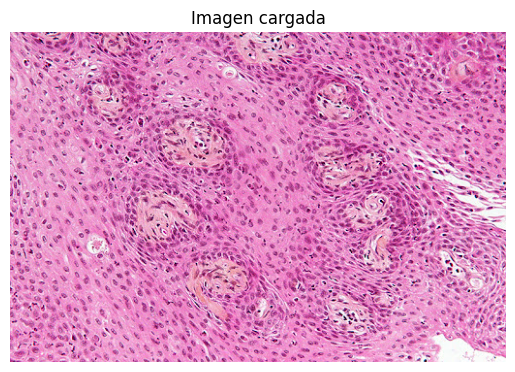


Verificador: histology (50.22% confianza)

✅ Clasificación: colon_aca (99.93% confianza)

 Distribución de probabilidades por clase:
- colon_aca      : 99.93%
- colon_n        : 0.02%
- lung_aca       : 0.00%
- lung_n         : 0.05%
- lung_scc       : 0.01%


In [ ]:
# SUBIR IMAGEN
print("Ahora sube una imagen para analizar:")
image_file = files.upload()
img_path = list(image_file.keys())[0]

# CARGAR Y MOSTRAR IMAGEN
image = Image.open(img_path).convert("RGB")
plt.imshow(image)
plt.axis("off")
plt.title("Imagen cargada")
plt.show()

# TRANSFORMAR
input_tensor = transform(image).unsqueeze(0).to(DEVICE)

# ETAPA 1: VERIFICADOR DE HISTOLOGÍA
with torch.no_grad():
    output = verifier_model(input_tensor)
    probs = F.softmax(output, dim=1)
    hist_pred = torch.argmax(probs, dim=1).item()
    hist_conf = probs[0, hist_pred].item()

print(f"\nVerificador: {HISTOLOGY_CLASSES[hist_pred]} ({hist_conf * 100:.2f}% confianza)")

# ETAPA 2: CLASIFICADOR (si pasa verificación)
if HISTOLOGY_CLASSES[hist_pred] == "histology":
    with torch.no_grad():
        output = classifier_model(input_tensor)
        probs = F.softmax(output, dim=1)
        cancer_pred = torch.argmax(probs, dim=1).item()
        cancer_conf = probs[0, cancer_pred].item()

    print(f"\n✅ Clasificación: {CANCER_CLASSES[cancer_pred]} ({cancer_conf * 100:.2f}% confianza)")

    print("\n Distribución de probabilidades por clase:")
    for i, (clase, prob) in enumerate(zip(CANCER_CLASSES, probs[0])):
        print(f"- {clase:<15}: {prob.item() * 100:.2f}%")
else:
    print("\n❌ La imagen no es reconocida como histológica.")